# Modeling and Evaluation - Predict House Price

## Objectives

* Fit and evaluate a classification model to predict a house sale price when the house features are known.

## Inputs
* outputs/datasets/collection/housing_data_cleaned.csv
* Feature engineering/data cleaning from the feature engineering notebook.

## Outputs 
* Train set
* Test set
* ML pipeline to predict house sale prices



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-ML-PROJECT/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-ML-PROJECT'

# Load Data

In [4]:
import pandas as pd
import numpy as np
df = (pd.read_csv("outputs/datasets/collection/housing_data_cleaned.csv"))
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,1.0,706.0,6.0,150.0,548.0,2.0,2003.0,...,8450.0,65.0,196.0,61.0,5,7,856.0,2003,2003,208500.0
1,1262.0,0.0,3.0,4.0,978.0,5.0,284.0,460.0,2.0,1976.0,...,9600.0,80.0,0.0,0.0,8,6,1262.0,1976,1976,181500.0
2,920.0,866.0,3.0,2.0,486.0,6.0,434.0,608.0,2.0,2001.0,...,11250.0,68.0,162.0,42.0,5,7,920.0,2001,2002,223500.0
3,961.0,0.0,3.0,1.0,216.0,5.0,540.0,642.0,1.0,1998.0,...,9550.0,60.0,0.0,35.0,5,7,756.0,1915,1970,140000.0
4,1145.0,0.0,4.0,3.0,655.0,6.0,490.0,836.0,2.0,2000.0,...,14260.0,84.0,350.0,84.0,5,8,1145.0,2000,2000,250000.0


## Create ML Pipeline

In [5]:
### Custom Encoder
from sklearn.base import BaseEstimator, TransformerMixin
class MyCustomEncoder(BaseEstimator, TransformerMixin):

  def __init__(self, variables, dic):
    if not isinstance(variables, list): 
      self.variables = [variables]
    else: self.variables = variables
    self.dic = dic

  def fit(self, X, y=None):    
    return self

  def transform(self, X):
    for col in self.variables:
      if X[col].dtype == 'object':
        X[col] = X[col].replace(dic[col])
      else:
        print(f"Warning: {col} data type should be object to use MyCustomEncoder()")
      
    return X

- **Import all necassary ML algorithms**

### Bring in the pipeline from the feature engineering notebook with feature scaling, feature selection and model added:

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(dic, vars_with_missing_data, model):
    
      pipeline = Pipeline([
            # ('drop_features', DropFeatures(features_to_drop = ['EnclosedPorch', 'WoodDeckSF'])),
             
            ('custom_encoder', MyCustomEncoder(variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'], dic=dic)),       
            
            ('median_imputer',  MeanMedianImputer(imputation_method='median', variables=vars_with_missing_data)),
            
            ('corr_sel', SmartCorrelatedSelection(method="spearman", threshold=0.6, selection_method="variance")),
            
            ("feat_scaling", StandardScaler() ),

            ("feat_selection",  SelectFromModel(model) ),

            ("model", model ),
      ])

      return pipeline


- **Hyperparameter optimization**: Custom hyperparameter optimization to fit my model

In [7]:
from sklearn.model_selection import GridSearchCV

class HyperparameterOptimizationSearch:

    def __init__(self, dic, vars_with_missing_data, models, params):
        self.dic = dic
        self.vars_with_missing_data = vars_with_missing_data
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(dic, vars_with_missing_data, self.models[key],)

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(np.array(r).reshape(-1, 1))


            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches
        

## Split the data into Train and Test sets

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print('Train Set:', X_train.shape, y_train.shape, 'Test Set:', X_test.shape, y_test.shape)

Train Set: (1168, 21) (1168,) Test Set: (292, 21) (292,)


## Grid Search CV from Scikit Learn

Lets try 7 ML models to find the best one

In [9]:
models_quick_search = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    "LinearRegression": {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [10]:
dic = {'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}, 'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}, 'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}, 'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}}
vars_with_missing_data = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea']     


# Train 5 models, 1 for each of 5 cross validations for each algorithm and the hyperparameters

In [11]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_

/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/workspace/.pip-modules/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


## Lets check the results

In [12]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.672712,0.803012,0.874444,0.075183
2,RandomForestRegressor,0.632989,0.791839,0.85964,0.083685
0,LinearRegression,0.701462,0.77925,0.824712,0.041363
5,GradientBoostingRegressor,0.614845,0.759047,0.850056,0.091379
6,XGBRegressor,0.637822,0.739428,0.827152,0.071499
4,AdaBoostRegressor,0.621051,0.71584,0.775451,0.058374
1,DecisionTreeRegressor,0.495511,0.6203,0.674645,0.068149


## Use hyperparameter optimization on the top 4 models using hyperparameter combinations

In [13]:
models_search = {
    "LinearRegression": LinearRegression(),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_search = {
    "LinearRegression":{},
    "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
                                 'model__learning_rate':[0.1, 0.01, 0.001],
                                 'model__max_depth': [3,15, None],
                                 'model__min_samples_split': [2,50],
                                 'model__min_samples_leaf': [1,50],
                                 'model__max_leaf_nodes': [None,50],
    },
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                           'model__max_depth': [None, 3, 15],
                           'model__min_samples_split': [2, 50],
                           'model__min_samples_leaf': [1,50],
    },
    "RandomForestRegressor":{'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
    },
}

## Train our models with Grid Search CV

* Totalling 1625 models

In [14]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_search, params=params_search)

search.fit(X_train, y_train, scoring= 'r2', n_jobs=1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


## Lets check the results

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.head(61)

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
243,ExtraTreesRegressor,0.666918,0.807807,0.877314,0.077076,NaN,15,NaN,1,2,150
222,ExtraTreesRegressor,0.754286,0.806116,0.855046,0.043113,NaN,None,NaN,1,50,150
246,ExtraTreesRegressor,0.754286,0.8061,0.855059,0.043107,NaN,15,NaN,1,50,150
244,ExtraTreesRegressor,0.75347,0.806001,0.853251,0.04265,NaN,15,NaN,1,50,100
220,ExtraTreesRegressor,0.75347,0.805992,0.85321,0.042641,NaN,None,NaN,1,50,100
...,...,...,...,...,...,...,...,...,...,...,...
44,GradientBoostingRegressor,0.667937,0.786303,0.84602,0.064873,0.1,15,50,50,2,50
47,GradientBoostingRegressor,0.667937,0.786303,0.84602,0.064873,0.1,15,50,50,50,50
71,GradientBoostingRegressor,0.667937,0.786303,0.84602,0.064873,0.1,None,50,50,50,50
68,GradientBoostingRegressor,0.667937,0.786303,0.84602,0.064873,0.1,None,50,50,2,50


### Now we will look into all 4 algorithms

## **1. ExtraTreesRegressor**

In [16]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

* Best model parameters

In [17]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

* Best model pipeline

In [18]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('custom_encoder',
                 MyCustomEncoder(dic={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                       'Mn': 2, 'No': 1,
                                                       'None': 0},
                                      'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                       'GLQ': 6, 'LwQ': 2,
                                                       'None': 0, 'Rec': 3,
                                                       'Unf': 1},
                                      'GarageFinish': {'Fin': 3, 'None': 0,
                                                       'RFn': 2, 'Unf': 1},
                                      'KitchenQual': {'Ex': 4, 'Fa': 1, 'Gd': 3,
                                                      'Po': 0, 'TA': 2}},
                                 variables=['BsmtExposure', 'BsmtFinType1',
                                            'GarageFinish', 'KitchenQ...
                                              'BsmtFinType1', 'GarageFinish',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=15, n_estimators=150,
                                     random_state=0))])

## Assess the Feature Importance

* These are the 5 most important features in descending order. The model was trained on them: 
['LotArea', 'BsmtUnfSF', 'MasVnrArea', 'LotFrontage', 'BsmtFinSF1']


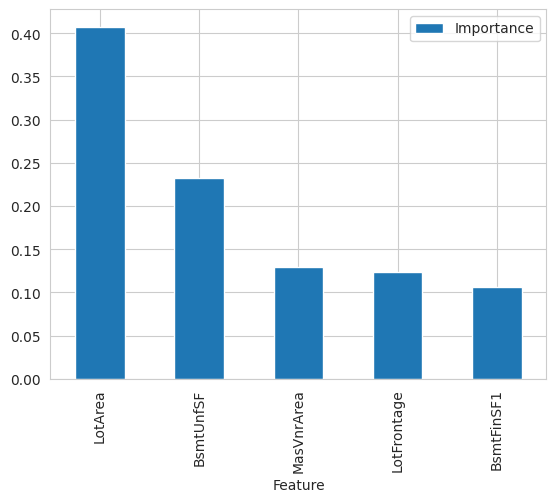

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Apply pipeline transformation to X_train
transformed_array = Pipeline(best_pipeline.steps[:4]).transform(X_train)

# Extract selected features correctly
selected_mask = best_pipeline['feat_selection'].get_support()
selected_features = [col for col, keep in zip(X_train.columns, selected_mask) if keep]

# Extract final selected features
best_features = selected_features

# Create DataFrame with selected feature importance
df_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the most important features
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot feature importance
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')

plt.show()


### Evaluate Train and Test Sets

In [20]:
# Following code is from a SKlearn lesson from Code Institute
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].tick_params(axis='x', rotation=90)
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].tick_params(axis='x', rotation=90)
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

plt.show()

### Evaluate Model Performance

Model Evaluation 

* Train Set
R2 Score: 0.998
Mean Absolute Error: 2031.201
Mean Squared Error: 10006565.89
Root Mean Squared Error: 3163.316


* Test Set
R2 Score: 0.864
Mean Absolute Error: 19491.898
Mean Squared Error: 939029175.811
Root Mean Squared Error: 30643.583




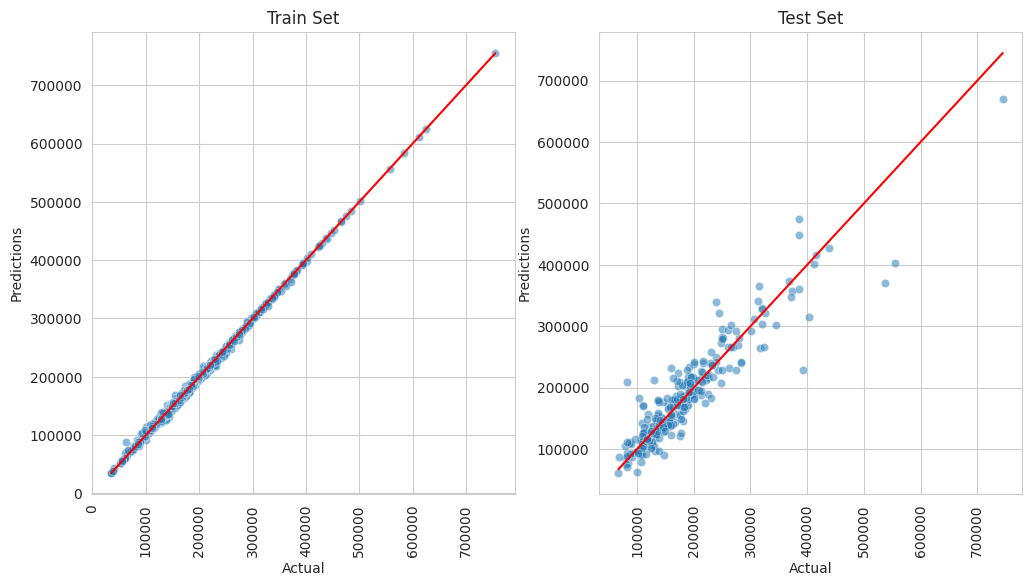

In [21]:
regression_performance(X_train, y_train, X_test, y_test,best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)


**The R2 score on the test set is 0.86, this means it passes the goal to perform above an R2 score of at least 0.75. This model is trained on 5 features.**

## **2. RandomForestRegressor**

In [22]:
best_model = grid_search_summary.iloc[12,0]
best_model

'RandomForestRegressor'

* Best model parameters

In [23]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': None,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

* Best model pipeline

In [24]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('custom_encoder',
                 MyCustomEncoder(dic={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                       'Mn': 2, 'No': 1,
                                                       'None': 0},
                                      'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                       'GLQ': 6, 'LwQ': 2,
                                                       'None': 0, 'Rec': 3,
                                                       'Unf': 1},
                                      'GarageFinish': {'Fin': 3, 'None': 0,
                                                       'RFn': 2, 'Unf': 1},
                                      'KitchenQual': {'Ex': 4, 'Fa': 1, 'Gd': 3,
                                                      'Po': 0, 'TA': 2}},
                                 variables=['BsmtExposure', 'BsmtFinType1',
                                            'GarageFinish', 'KitchenQ...
                                              'BsmtFinType1', 'GarageFinish',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestRegressor(random_state=0))),
                ('model',
                 RandomForestRegressor(max_leaf_nodes=50, random_state=0))])

## Assess the Feature Importance

* These are the 5 most important features in descending order. The model was trained on them: 
['LotArea', 'BsmtUnfSF']


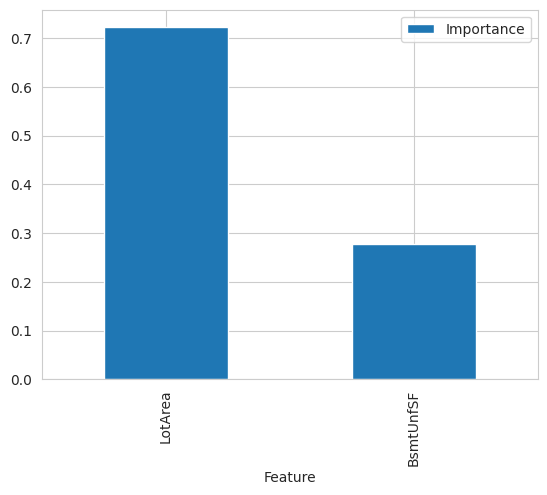

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Apply pipeline transformation to X_train
transformed_array = Pipeline(best_pipeline.steps[:4]).transform(X_train)

# Extract selected features correctly
selected_mask = best_pipeline['feat_selection'].get_support()
selected_features = [col for col, keep in zip(X_train.columns, selected_mask) if keep]

# Create DataFrame with selected feature importance
df_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the most important features
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot feature importance
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


### Evaluate Model Performance

Model Evaluation 

* Train Set
R2 Score: 0.864
Mean Absolute Error: 21851.806
Mean Squared Error: 837623498.196
Root Mean Squared Error: 28941.726


* Test Set
R2 Score: 0.796
Mean Absolute Error: 24320.864
Mean Squared Error: 1410871090.105
Root Mean Squared Error: 37561.564




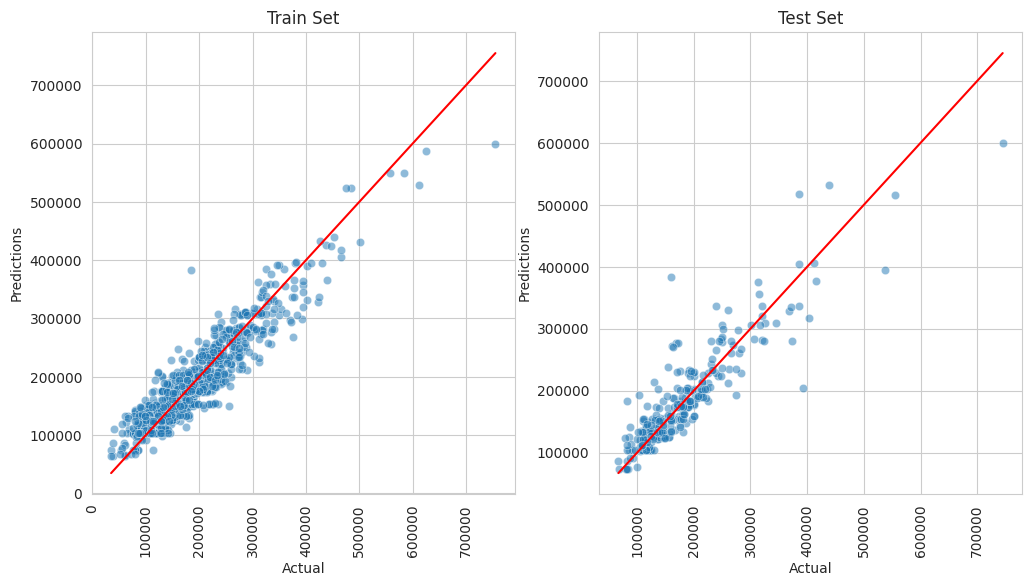

In [26]:
regression_performance(X_train, y_train, X_test, y_test,best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)


**The R2 score on the test set is 0.79, this means it passes the goal to perform above an R2 score of at least 0.75. This is a great result and may be the best model, however it may have trouble predicting price above £400,000**

## 3. GradientBoostingRegressor

In [27]:
best_model = grid_search_summary.iloc[19,0]
best_model

'GradientBoostingRegressor'

* Best model parameters

In [28]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

* Best model pipeline

In [29]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('custom_encoder',
                 MyCustomEncoder(dic={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                       'Mn': 2, 'No': 1,
                                                       'None': 0},
                                      'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                       'GLQ': 6, 'LwQ': 2,
                                                       'None': 0, 'Rec': 3,
                                                       'Unf': 1},
                                      'GarageFinish': {'Fin': 3, 'None': 0,
                                                       'RFn': 2, 'Unf': 1},
                                      'KitchenQual': {'Ex': 4, 'Fa': 1, 'Gd': 3,
                                                      'Po': 0, 'TA': 2}},
                                 variables=['BsmtExposure', 'BsmtFinType1',
                                            'GarageFinish', 'KitchenQ...
                                              'BsmtFinType1', 'GarageFinish',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(min_samples_leaf=50,
                                           random_state=0))])

## Assess Feature Importance

* These are the 5 most important features in descending order. The model was trained on them: 
['LotArea', 'BsmtUnfSF', 'LotFrontage']


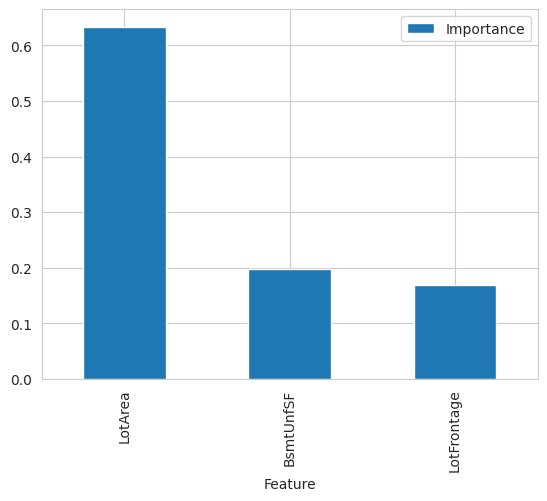

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Apply pipeline transformation to X_train
transformed_array = Pipeline(best_pipeline.steps[:4]).transform(X_train)

# Extract selected features correctly
selected_mask = best_pipeline['feat_selection'].get_support()
selected_features = [col for col, keep in zip(X_train.columns, selected_mask) if keep]

# Create DataFrame with selected feature importance
df_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the most important features
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot feature importance
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

### Evaluate Model Performance

Model Evaluation 

* Train Set
R2 Score: 0.83
Mean Absolute Error: 21547.796
Mean Squared Error: 1046670409.555
Root Mean Squared Error: 32352.286


* Test Set
R2 Score: 0.764
Mean Absolute Error: 24224.365
Mean Squared Error: 1626838403.127
Root Mean Squared Error: 40334.085




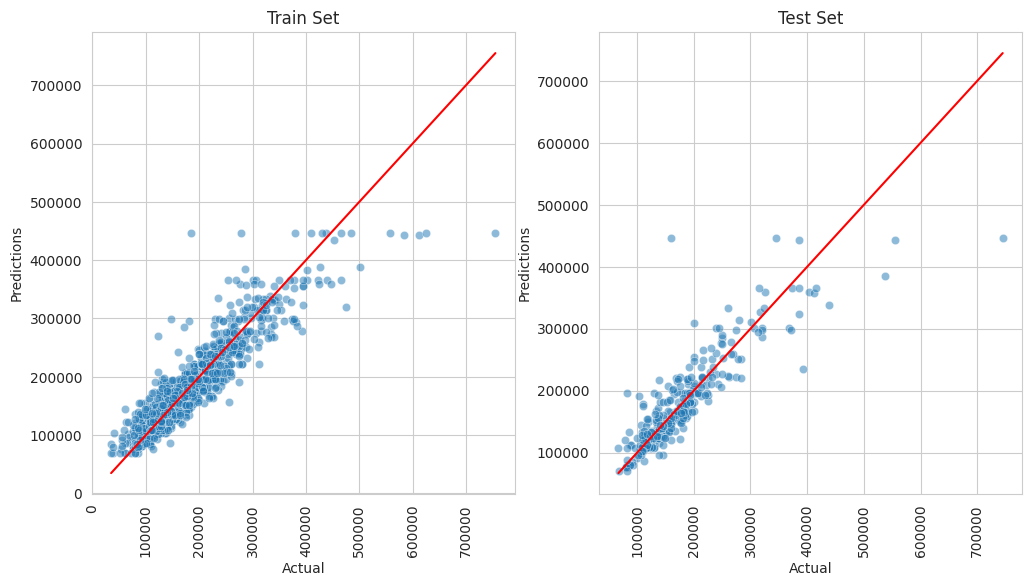

In [31]:
regression_performance(X_train, y_train, X_test, y_test,best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)

**The R2 score on the test set is 0.76. It passes the R2 performance requirement of 0.75 however the model is has not predicted any values above circa £450,000.**

## 4. LinearRegression

In [32]:
best_model = grid_search_summary.iloc[60,0]
best_model

'LinearRegression'

* Best model parameters

In [33]:
grid_search_pipelines[best_model].best_params_

{}

* Best model pipeline

In [34]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline


Pipeline(steps=[('custom_encoder',
                 MyCustomEncoder(dic={'BsmtExposure': {'Av': 3, 'Gd': 4,
                                                       'Mn': 2, 'No': 1,
                                                       'None': 0},
                                      'BsmtFinType1': {'ALQ': 5, 'BLQ': 4,
                                                       'GLQ': 6, 'LwQ': 2,
                                                       'None': 0, 'Rec': 3,
                                                       'Unf': 1},
                                      'GarageFinish': {'Fin': 3, 'None': 0,
                                                       'RFn': 2, 'Unf': 1},
                                      'KitchenQual': {'Ex': 4, 'Fa': 1, 'Gd': 3,
                                                      'Po': 0, 'TA': 2}},
                                 variables=['BsmtExposure', 'BsmtFinType1',
                                            'GarageFinish', 'KitchenQ...
                 MeanMedianImputer(variables=['2ndFlrSF', 'BedroomAbvGr',
                                              'BsmtFinType1', 'GarageFinish',
                                              'GarageYrBlt', 'LotFrontage',
                                              'MasVnrArea'])),
                ('corr_sel',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=LinearRegression())),
                ('model', LinearRegression())])

## Assess Feature Importance

LinearRegression has no feature importance so we can remove the df_feature_importance from this assessment

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Apply pipeline transformation to X_train
transformed_array = Pipeline(best_pipeline.steps[:4]).transform(X_train)

# Extract selected features correctly
selected_mask = best_pipeline['feat_selection'].get_support()
selected_features = [col for col, keep in zip(X_train.columns, selected_mask) if keep]


### Evaluate Model Performance

Model Evaluation 

* Train Set
R2 Score: 0.788
Mean Absolute Error: 24386.607
Mean Squared Error: 1307079791.351
Root Mean Squared Error: 36153.558


* Test Set
R2 Score: 0.63
Mean Absolute Error: 27184.477
Mean Squared Error: 2554927208.497
Root Mean Squared Error: 50546.288




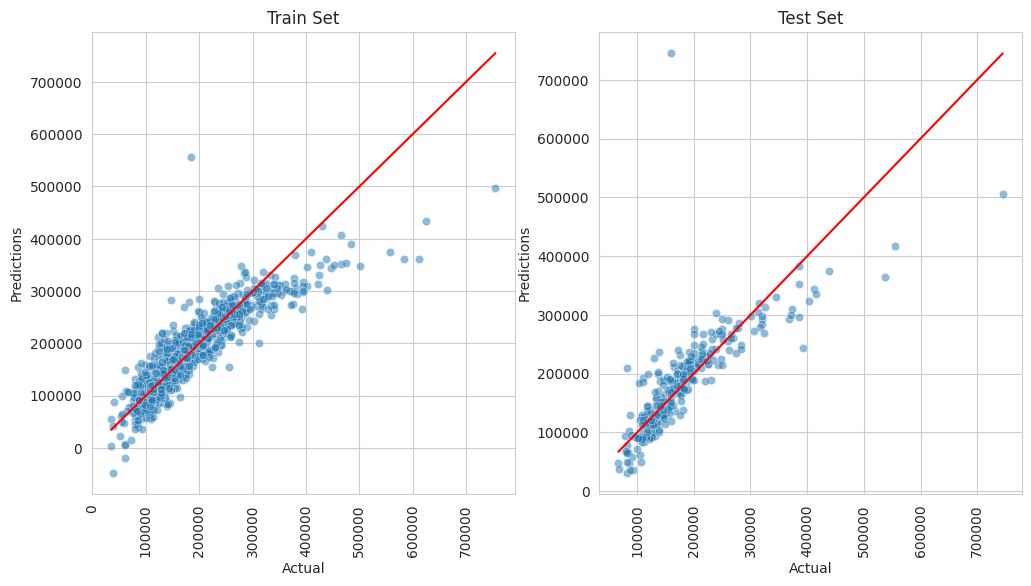

In [36]:
regression_performance(X_train, y_train, X_test, y_test,best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)

**The R2 score on the test set is 0.63. It does not pass the R2 performance requirement of 0.75.**

# Refit the pipeline with best features

**We chose to fit RandomForestRegressor**

In [73]:
best_model = grid_search_summary.iloc[12,0]
best_model

'RandomForestRegressor'

In [74]:
grid_search_pipelines[best_model].best_params_


{'model__max_depth': 10,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 5,
 'model__n_estimators': 200}

In [75]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=5,
                                       min_samples_split=5,
                                       n_estimators=200))])

## Assess Feature Importance

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')

# Apply pipeline transformation to X_train
transformed_array = Pipeline(best_pipeline.steps[:4]).transform(X_train)

# Extract selected features correctly
selected_mask = best_pipeline['feat_selection'].get_support()
selected_features = [col for col, keep in zip(X_train.columns, selected_mask) if keep]

# Extract final selected features
best_features = selected_features

# Create DataFrame with selected feature importance
df_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the most important features
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

# Plot feature importance
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


AttributeError: This 'Pipeline' has no attribute 'transform'

**The RandomForestRegressor pipeline is only trained on 2 features out of the 23 so we updated the pipeline, training set and test set so that the model is smaller and can be more efficient when predicting sale price**

In [59]:
def PipelineOptimization(dic, vars_with_missing_data, model):
    
      pipeline = Pipeline([
            # ('median_imputer', MeanMedianImputer(imputation_method='median', variables=vars_with_missing_data)),
            # ('corr_sel', SmartCorrelatedSelection(method="spearman", threshold=0.75)),  # Less strict correlation
            ("feat_scaling", StandardScaler()),
            # ("feat_selection", SelectFromModel(RandomForestRegressor(n_estimators=200), threshold=-np.inf, max_features=12)),
            ("model", RandomForestRegressor(n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2))
])


      return pipeline

## Update the Train Set and Test Set

In [60]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 2) (1168,) 
* Test set: (292, 2) (292,)


,BsmtUnfSF,LotArea
618,1774.0,11694.0
870,894.0,6600.0
92,163.0,13360.0


## Grid Search CV - SciKit Learn

In [61]:
models_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_search = {
    "RandomForestRegressor": {
        'model__n_estimators': [200, 300],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 5],
        'model__max_leaf_nodes': [None, 100]
    }
}


### Train the new models with GridSearchCV

In [62]:
search = HyperparameterOptimizationSearch(dic=dic, vars_with_missing_data=vars_with_missing_data, models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


### Show the Results

In [51]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
14,RandomForestRegressor,0.163756,0.243172,0.312718,0.050132,10,None,5,5,200
34,RandomForestRegressor,0.165518,0.242828,0.318032,0.050529,10,100,5,10,200
30,RandomForestRegressor,0.16714,0.241605,0.32022,0.049565,10,100,5,2,200
17,RandomForestRegressor,0.166767,0.241469,0.314903,0.048566,10,None,5,10,300
12,RandomForestRegressor,0.169628,0.241027,0.309792,0.045183,10,None,5,2,200
...,...,...,...,...,...,...,...,...,...,...
39,RandomForestRegressor,0.07743,0.181068,0.249981,0.056461,20,None,1,5,300
73,RandomForestRegressor,0.032903,0.158199,0.238738,0.067867,None,None,1,2,300
72,RandomForestRegressor,0.025312,0.156744,0.236233,0.070407,None,None,1,2,200
36,RandomForestRegressor,0.023599,0.155488,0.244234,0.07242,20,None,1,2,200


In [52]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestRegressor'

In [53]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline


Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=5,
                                       min_samples_split=5,
                                       n_estimators=200))])

Model Evaluation 

* Train Set
R2 Score: 0.538
Mean Absolute Error: 37559.568
Mean Squared Error: 2843579248.269
Root Mean Squared Error: 53325.222


* Test Set
R2 Score: 0.206
Mean Absolute Error: 48776.959
Mean Squared Error: 5483855936.077
Root Mean Squared Error: 74053.062




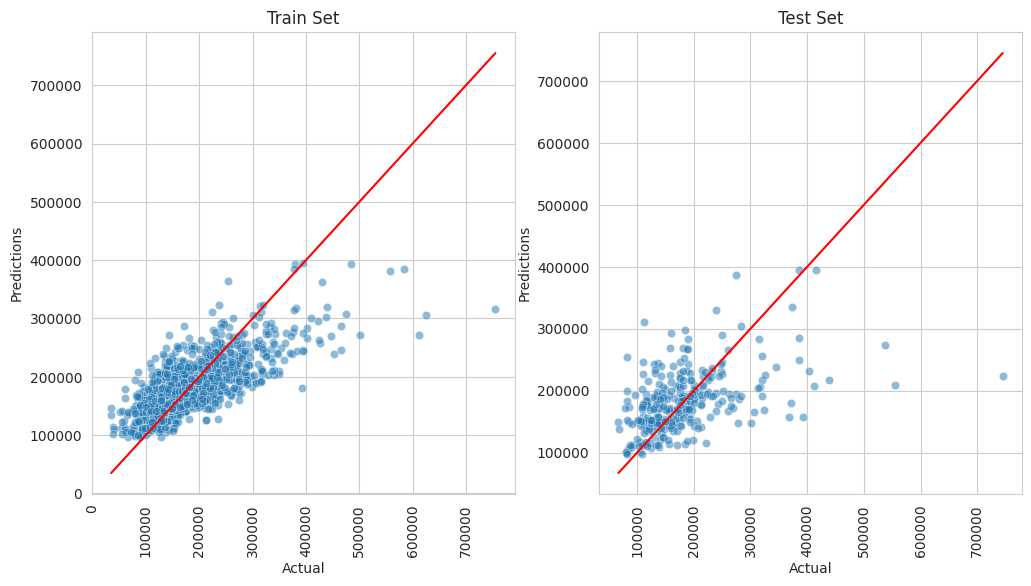

In [54]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)

* **These were not the results we wanted so I will now try to manually train the model on the 2 strongest correlated features that we found from the HouseSalePriceCorrelation notebook.**

### Refit the model with 2 strongly correlated features

Import everything we'll need

In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, r2_score

* **First lets get the 2 most strongly correlated features**

In [106]:
corr_matrix = df.corr()

# Get top 2 features correlated with SalePrice (excluding SalePrice itself)
top_features = corr_matrix["SalePrice"].drop("SalePrice").abs().sort_values(ascending=False).head(2).index.tolist()

print("Top 2 features correlated with SalePrice:", top_features)


Top 2 features correlated with SalePrice: ['OverallQual', 'GrLivArea']


* As expected we can see that they are the Overall Quality and the Groud Living Area m^2.

### Split the new train and test data

In [108]:
# Use only the top 2 correlated features
X = df[top_features]  
y = df["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape)

(1168, 2) (292, 2)


#### **Train the Models**

In [121]:
# Define models in a dictionary
models = {
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=0),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=0),
}

# Train, predict, and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} Performance with Top 2 Features:\nMAE: {mae:.2f}, R²: {r2:.4f}\n")


Linear Regression Performance with Top 2 Features:
MAE: 28959.03, R²: 0.6750

Gradient Boosting Performance with Top 2 Features:
MAE: 22713.13, R²: 0.8428

Random Forest Performance with Top 2 Features:
MAE: 27463.44, R²: 0.7538

Extra Trees Performance with Top 2 Features:
MAE: 29284.57, R²: 0.7229



* **As we can see there are only 2 models here that are over the 0.75 that the client asked for which are the 'GradientBoostingRegressor' and 'RandomForestRegressor'. The 'GradientBoostingRegressor' performance is much better as it has a lower MAE and higher R2 score meaning it can more accurately predict 'SalePrice'**

In [138]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Initialize the model
gb_model = GradientBoostingRegressor(random_state=0)

# Perform Grid Search
grid_search = GridSearchCV(gb_model, param_grid, cv=5, n_jobs=-1, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

best_gb_model = grid_search.best_estimator_

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the tuned model
y_pred = grid_search.best_estimator_.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Tuned Gradient Boosting Model Performance:\nMAE: {mae:.2f}, R²: {r2:.4f}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tot

* After tuning the GDR we see that it still has a lower MAE score and high enough R2 score we can now use this to predict house prices

### Save all the files neccassary from the notebook

In [126]:
import joblib
import os

version = 'v1'
file_path = f'outputs/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

#### Save Train Set:

In [127]:
X_train.head()


,OverallQual,GrLivArea
618,9,1828.0
870,5,894.0
92,5,964.0
817,8,1689.0
302,7,1541.0


In [128]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [129]:
y_train.head()

618    314813.0
870    109500.0
92     163500.0
817    271000.0
302    205000.0
Name: SalePrice, dtype: float64

In [130]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

#### Save Test Set:

In [131]:
X_test.head()

,OverallQual,GrLivArea
529,6,2515.0
491,6,1578.0
459,5,1203.0
279,7,2022.0
655,6,1092.0


In [132]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [133]:
y_test.head()

529    200624.0
491    133000.0
459    110000.0
279    192000.0
655     88000.0
Name: SalePrice, dtype: float64

In [134]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

#### Modeling Pipeline

In [139]:
best_gb_model

GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=5,
                          random_state=0)

In [140]:
joblib.dump(value=best_gb_model, filename=f"{file_path}/best_gb_model.pkl")

['outputs/predict_price/v1/best_gb_model.pkl']